In [1]:
import sys
sys.path = ["/afs/cern.ch/work/d/dvalsecc/private/ttHbb/PocketCoffea/myenv/lib/python3.9/site-packages"] + sys.path

In [2]:
import awkward as ak
import numba
import numpy as np
import pandas as pd
import awkward as ak
import vector
vector.register_numba()
vector.register_awkward()
import os

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep
hep.style.use(hep.style.ROOT)

from importlib import reload

import numba
import spanet_predictions

In [3]:
@numba.njit
def assign_provenance_and_prob(t1pred, t2pred, hpred, 
                      t1prob, t2prob, hprob, njets):
    out = np.zeros((t1pred.shape[0], njets)) -1
    prob = np.zeros((t1pred.shape[0], njets, 3), dtype=np.float32)-np.float32(np.inf)
    
    #print(prob)
    for iev, (t1, t2, h, t1p, t2p, hp) in enumerate(zip(t1pred, t2pred, hpred, t1prob, t2prob, hprob)):
    
        if t1[0] == -2:
            prob_t1 = -np.inf
        else:
            prob_t1 = t1p[t1[0]][t1[1]][t1[2]]
            
        if t2[0] == -2:
            prob_t2 = -np.inf
        else:
            prob_t2 = t2p[t2[0]]
            
        if h[0] == -2:
            prob_h = -np.inf
        else:
            prob_h = hp[h[0]][h[1]]
            
        
        # prob_t1 = t1p[t1[0]][t1[1]][t1[2]]
        # prob_t2 = t2p[t2[0]][t2[1]]
        # prob_h = hp[h[0]][h[1]]
        # print(prob_t1, prob_t2, prob_h)
        
        for i in t1: 
            out[iev][i] = 1
            prob[iev][i][0] = prob_t1
        for i in t2: 
            out[iev][i] = 2
            prob[iev][i][1] = prob_t2
        for i in h: 
            out[iev][i] = 3
            prob[iev][i][2] = prob_h

    return out, prob

In [4]:
import onnxruntime    # to inference ONNX models, we use the ONNX Runtime
sess_options = onnxruntime.SessionOptions()

sess_options.intra_op_num_threads = 2
sess_options.inter_op_num_threads = 2
#sess_options.intra_op_num_threads = 15
sess_options.execution_mode = onnxruntime.ExecutionMode.ORT_PARALLEL
sess_options.graph_optimization_level = onnxruntime.GraphOptimizationLevel.ORT_ENABLE_ALL


session = onnxruntime.InferenceSession(
    f"/afs/cern.ch/user/m/mmarcheg/public/forDavide/models/multiclassifier_full_Run2_btag_LMH_8M_balance_events/spanet.onnx", 
    sess_options = sess_options,
    providers=['CUDAExecutionProvider', 'CPUExecutionProvider']
)

for input in session.get_inputs():
    print(f"{input.name}, {input.shape}")
    
for output in session.get_outputs():
    print(f"{output.name}, {output.shape}")



/afs/cern.ch/work/d/dvalsecc/private/ttHbb/PocketCoffea/myenv/lib/python3.9/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Jet_data, ['batch_size', 'num_Jet', 7]
Jet_mask, ['batch_size', 'num_Jet']
Met_data, ['batch_size', 'num_Met', 4]
Met_mask, ['batch_size', 'num_Met']
Lepton_data, ['batch_size', 'num_Lepton', 5]
Lepton_mask, ['batch_size', 'num_Lepton']
Event_data, ['batch_size', 'num_Event', 1]
Event_mask, ['batch_size', 'num_Event']
t1_assignment_probability, ['Expt1_assignment_probability_dim_0', 'Expt1_assignment_probability_dim_1', 'Expt1_assignment_probability_dim_2', 'Expt1_assignment_probability_dim_3']
t2_assignment_probability, ['Expt1_assignment_probability_dim_0', 'Expt1_assignment_probability_dim_1']
h_assignment_probability, ['Expt1_assignment_probability_dim_0', 'Expt1_assignment_probability_dim_1', 'Expt1_assignment_probability_dim_2']
t1_detection_probability, ['Expt1_assignment_probability_dim_0']
t2_detection_probability, ['Expt1_assignment_probability_dim_0']
h_detection_probability, ['Expt1_assignment_probability_dim_0']
EVENT/tthbb, ['SoftmaxEVENT/tthbb_dim_0', 2]
EVENT/ttbb, ['So

In [5]:
df = ak.from_parquet('/eos/user/d/dvalsecc/www/ttHbbAnalysis/training_dataset/v3_sig_forTrainingDataset/all_jets_fullRun2_ttHbb_forTraining_allyears_spanetprov_part1_train.parquet')

In [6]:
df.fields

['partons_matched',
 'partons',
 'generator_info',
 'lepton_partons',
 'lepton_reco',
 'met',
 'higgs',
 'weight',
 'prob_ak',
 'jets']

In [7]:
ak.unzip(df)

(<Array [[{pt: 262, eta: 1.2, ... prov: 1}]] type='1612912 * var * ?{"pt": float6...'>,
 <Array [[{pt: 262, eta: 1.2, ... prov: 1}]] type='1612912 * var * {"pt": float64...'>,
 <Array [{pdgid1: 21, ... x2: 0.0865}] type='1612912 * {"pdgid1": int32, "pdgid2"...'>,
 <Array [[{pt: 45, ... pdgId: -12}]] type='1612912 * var * {"pt": float32, "eta":...'>,
 <Array [[{pt: 44.2, eta: -0.465, ... m: 0}]] type='1612912 * var * {"pt": float3...'>,
 <Array [{pt: 93.1, eta: 0, ... m: 0}] type='1612912 * {"pt": float32, "eta": flo...'>,
 <Array [[{pt: 114, eta: -0.424, ... m: 125}]] type='1612912 * var * {"pt": float...'>,
 <Array [2.14e+03, 1.26e+03, ... 1.22e+03] type='1612912 * float64'>,
 <Array [[[0, 0, 0], ... [0.223, 0, 0.84]]] type='1612912 * var * 3 * float64'>,
 <Array [[{pt: 248, ... prov_H: 0.84}]] type='1612912 * var * {"pt": float32, "et...'>)

In [8]:
jets = ak.with_name(df.jets, name="Momentum4D")
lep = ak.with_name(df.lepton_reco, name="Momentum4D")
met = ak.with_name(df.met, name="Momentum4D")

In [9]:
jets

<MomentumArray4D [[{pt: 248, ... prov_H: 0.84}]] type='1612912 * var * Momentum4...'>

In [10]:
jets_padded = ak.fill_none(ak.pad_none(jets, 16, clip=True), {"btag":0., "pt":0., "phi":0., "eta":0.})

data = np.transpose(
    np.stack([
    ak.to_numpy(jets_padded.btag),  #WRONG --> just for testing
    ak.to_numpy(jets_padded.btag),
    ak.to_numpy(jets_padded.btag),
    ak.to_numpy(jets_padded.eta),
        ak.to_numpy(jets_padded.phi),
    ak.to_numpy(jets_padded.phi),
    ak.to_numpy(jets_padded.pt),
    
    ]),
    axes=[1,2,0]).astype(np.float32)

mask = ~ak.to_numpy(jets_padded.pt == 0)

met_data = np.stack([ak.to_numpy(met.eta),
                     ak.to_numpy(met.phi),
                     ak.to_numpy(met.phi),
                     #ak.to_numpy(met.pt)
                     np.log(1+ ak.to_numpy(met.pt))
                    ], axis=1)[:,None,:].astype(np.float32)

lep_data = np.stack([ak.to_numpy(lep[:,0].eta),
                     ak.to_numpy(lep[:,0].phi),
                     ak.to_numpy(lep[:,0].phi),
                     ak.to_numpy(lep[:,0].phi),
                     #ak.to_numpy(lep[:,0].pt)
                     np.log(1+ ak.to_numpy(lep[:,0].pt))
                ], axis=1)[:,None,:].astype(np.float32)

ht_array = np.sum(ak.to_numpy(jets_padded.pt), axis=1)[:,None, None].astype(np.float32)

mask_global = np.ones(shape=[met_data.shape[0], 1]) == 1

njets_good = ak.sum(mask, axis=1)

In [11]:
start = 0
stop = 10000
outputs = session.run(input_feed={
        "Jet_data": data[start:stop],
        "Jet_mask": mask[start:stop],
        "Met_data": met_data[start:stop],
        "Met_mask": mask_global[start:stop],
        "Lepton_data": lep_data[start:stop],
        "Lepton_mask": mask_global[start:stop],
        "Event_data": ht_array[start:stop], 
        "Event_mask": mask_global[start:stop]},
        output_names=["t1_assignment_probability", "t2_assignment_probability",
                     "h_assignment_probability",
                     "EVENT/tthbb","EVENT/ttbb", "EVENT/ttlf"]
        )

In [12]:
outputs

[array([[[[0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.00171918, ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.00427722, 0.        , ..., 0.        ,
           0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ]],
 
         [[0.        , 0.        , 0.00171918, ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.02992899, 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        , ..., 0.        ,
   

(array([1.000e+00, 3.000e+00, 2.000e+00, 4.000e+00, 2.000e+00, 3.000e+00,
        4.000e+00, 5.000e+00, 1.400e+01, 1.000e+01, 1.300e+01, 2.200e+01,
        2.500e+01, 3.800e+01, 4.200e+01, 5.300e+01, 5.900e+01, 6.900e+01,
        9.600e+01, 9.600e+01, 1.450e+02, 1.310e+02, 1.740e+02, 1.970e+02,
        2.340e+02, 2.360e+02, 2.490e+02, 2.720e+02, 3.040e+02, 3.100e+02,
        2.900e+02, 3.200e+02, 3.250e+02, 3.030e+02, 3.220e+02, 3.130e+02,
        3.150e+02, 3.200e+02, 3.230e+02, 2.830e+02, 2.510e+02, 2.270e+02,
        2.360e+02, 2.380e+02, 1.870e+02, 2.190e+02, 1.950e+02, 2.640e+02,
        1.114e+03, 1.142e+03]),
 array([0.29943594, 0.31321916, 0.32700238, 0.34078559, 0.35456881,
        0.36835203, 0.38213524, 0.39591846, 0.40970168, 0.42348489,
        0.43726811, 0.45105132, 0.46483454, 0.47861776, 0.49240097,
        0.50618416, 0.51996738, 0.53375059, 0.54753381, 0.56131703,
        0.57510024, 0.58888346, 0.60266668, 0.61644989, 0.63023311,
        0.64401633, 0.65779954, 0.67

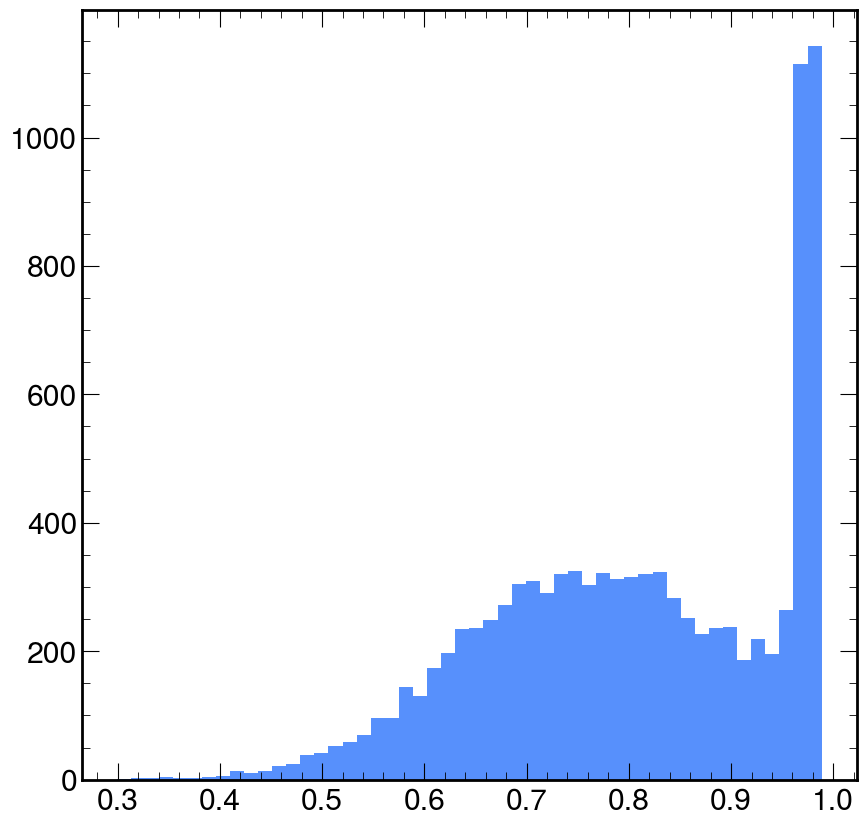

In [35]:
#plt.hist(outputs[-3][:,0])
plt.hist(outputs[-3][:,0], bins=50)

In [25]:
preds_nomask = spanet_predictions.extract_predictions([np.log(outputs[0]),
                                                       np.log(outputs[1]), 
                                                       np.log(outputs[2])], masking=False)

/tmp/dvalsecc/ipykernel_2057625/3152077916.py:1: RuntimeWarning: divide by zero encountered in log
  preds_nomask = spanet_predictions.extract_predictions([np.log(outputs[0]),
/tmp/dvalsecc/ipykernel_2057625/3152077916.py:2: RuntimeWarning: divide by zero encountered in log
  np.log(outputs[1]),
/tmp/dvalsecc/ipykernel_2057625/3152077916.py:3: RuntimeWarning: divide by zero encountered in log
  np.log(outputs[2])], masking=False)


prov, prob = assign_provenance_and_prob(*preds_nomask, np.log(outputs[0]), 
                                        np.log(outputs[1]), np.log(outputs[2]), 16)

In [34]:
np.exp(prob).shape

(10000, 16, 3)

In [29]:
preds_nomask[0]

array([[1, 3, 0],
       [0, 1, 3],
       [0, 1, 5],
       ...,
       [2, 3, 4],
       [1, 2, 0],
       [4, 5, 2]])

In [21]:
outputs[2].shape

(10000, 16, 16)

In [23]:
outputs[0].shape

(10000, 16, 16, 16)

In [ ]:
provenance = np.zeros((data.shape[0], 16))
prob_assignment = np.zeros((data.shape[0], 16, 3))


for i in track(range(nbatches), "Inference"):
#for i in range(nbatches):
    if i> 10: break
    #print(f"EVAL {i}")
    start = i*batch_size
    if i < (nbatches-1):
        stop = start+batch_size
    else:
        stop = len(data)
    outputs = session.run(input_feed={
        "Source_data": data[start:stop],
        "Source_mask": mask[start:stop],
        "Met_data": met_data[start:stop],
        "Met_mask": mask_global[start:stop],
        "Lepton_data": lep_data[start:stop],
        "Lepton_mask": mask_global[start:stop],
        "ht_data": ht_array[start:stop], 
        "ht_mask": mask_global[start:stop]},
        output_names=["t1_assignment_log_probability", "t2_assignment_log_probability",
                     "h_assignment_log_probability"]
        )
    #print(outputs)
    preds_nomask = spanet_predictions.extract_predictions(outputs[0:3], masking=False)
    prov, prob = assign_provenance_and_prob(*preds_nomask, outputs[0], outputs[1], outputs[2], 16)
    #print(prob)
    provenance[start:stop] = prov
    prob_assignment[start:stop]= prob